# IMDB Text Sentiment Classification with Conv1D

- Word Seq -> Embedding ->  **Conv1d**  ->  Linear -> SoftMax
 

**TODO Later sometime**
- LSTM/GRU

In [1]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets

In [2]:
%matplotlib inline

## Get IMDB sentiment classification data set
1. https://ai.stanford.edu/~amaas/data/sentiment/
1. Download, decompress

- The data was collected by Stanford researchers 
- and was used in a 2011 paper where a splitof 50-50 of the data was used for training and test. 
- An accuracy of 88.89% was achieved.

In [3]:
import os
os.listdir('.data/imdb/aclImdb/')

['imdb.vocab', 'imdbEr.txt', 'my_imdb.pkl', 'README', 'test', 'train']

In [4]:
# run $ python3 imdb_data_load.py to generate a pkl file from IMDB dataset

import imdb_data_load
xtr, ytr, xte, yte = imdb_data_load.load_imdb('.data/imdb/aclImdb', loadpkl=False)

load_imdb():  .data/imdb/aclImdb\my_imdb.pkl
load_from: .data/imdb/aclImdb\train/pos
load_from: .data/imdb/aclImdb\train/neg
12500 12500
load_from: .data/imdb/aclImdb\test/pos
load_from: .data/imdb/aclImdb\test/neg
12500 12500


### Let's have a look at the data

In [5]:
i = 0
print(f'label: {ytr[i]}\ndata[{i}]: (len: {len(xtr[i])}) {xtr[i][:10]}')
print('---')
print('xtr[0]>> ', xtr[0])
print('---')
print('xtr[500]>>', xtr[500])

label: 1
data[0]: (len: 140) ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the']
---
xtr[0]>>  ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........

## Vocabulary Making

- Vocab must be constructed with training data only.

In [6]:
vocab_src = set() # empty set
for word_list in xtr:
    vocab_src.update(word_list)
#
len(vocab_src)

280617

### Mapping from index to word, word to index

In [7]:
def get_maps(vocab):
    print('get_maps: ', len(vocab))
    word2indx, indx2word = {}, {}
    for v, w in enumerate(vocab):
        word2indx[w] = v
        indx2word[v] = w    # this can just be a list instead of {}
    return word2indx, indx2word
#

def get_words(i2w, inds):
    return [i2w[i] for i in inds]

word2indx_src, indx2word_src = get_maps(vocab_src)

get_maps:  280617


### Histogram of words in the whole dataset

- must include unknown word from test dataset

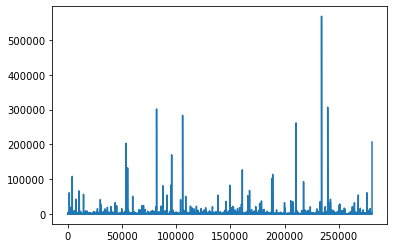

In [8]:
hist = np.zeros(len(vocab_src)+1, dtype=np.int)

for list_of_strings in [xtr, xte]:
    for wlst in list_of_strings:
        for w in wlst:
            if w in vocab_src:
                i = word2indx_src[w]
                hist[i] += 1
            else:
                hist[-1] += 1
plt.plot(hist)

In [9]:
print(f'* Maximum frequently used word: ', indx2word_src[np.argmax(hist)])
print(f'* Frequent Words:')
for i in range(len(vocab_src)):
    if hist[i] > 50000:
        print(indx2word_src[i], hist[i], end='; ')

* Maximum frequently used word:  the
* Frequent Words:
movie 60762; it 107916; but 66282; are 56513; is 203056; I 132498; you 50697; and 301919; for 80919; his 54198; as 83130; in 169981; of 283625; be 50539; have 54009; with 82569; that 126818; not 52140; The 67317; /><br 100974; this 113726; to 261850; was 92658; the 568735; a 306960; film 54277; on 61197; 

## Choose words and make a new vocab

In [10]:
mask = (7 <= hist ) & (hist < 50000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))
#
unk_indx = word2indx['<UNK>']
pad_indx = word2indx['<PAD>']

Chosen words: 58437  among  (280618,)
get_maps:  58441
size of new vocab:  58441


In [11]:
len(vocab), len(set(vocab))

(58441, 58441)

## Convert sentence (word-list) to list of integer index
- Embedding will be used for NN model

### Examine the lengths of all the sentences

mean: 233.7872, min: 10  max: 2470  std: 173.7, median: 174.0


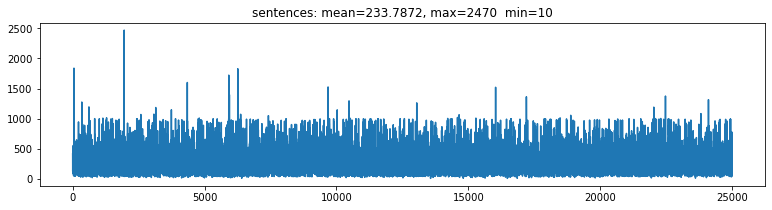

In [12]:
length = np.array([len(wlst) for wlst in xtr])
print(f'mean: {length.mean()}, min: {length.min()}  max: {length.max()}  std: {length.std():.1f}, median: {np.median(length)}')

plt.figure(figsize=(13,3))
plt.plot(length)
plt.title(f'sentences: mean={length.mean()}, max={max(length)}  min={min(length)}');

## Make Tensor array

In [13]:
max_len = 100  # we will use only 100 words per a sentence

In [14]:
def wseq2numpy(seq, vocab, word2indx, indx2word, max_len=200):
    """ seq: input, list of list of words, xtr or xte
        out: numpy array of ints [ [ 100, 23, 32], [32, 22, 10], ...]
    """
    print(len(seq), max_len)
    
    out = np.zeros((len(seq), max_len), dtype=np.int64)
    
    for i in range(len(seq)):
        s = seq[i]
        a = out[i]
        if len(s) >= max_len:   # if longer, trim
            s = s[:max_len]
        else:
            s = s + ['<PAD>' for i in range(max_len-len(s))]  # if shorter, pad
            
        for j, w in enumerate(s): # change to index 
            if w in vocab:
                a[j] = word2indx[w]
            else:
                a[j] = word2indx['<UNK>']
                
        if i == 0:
            print(f'{i} {seq[i]}')
    #
    return out

In [15]:
# set searching is much much faster than list searching
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

25000 100
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of'

In [16]:
xtrain.shape, xtrain[0]

((25000, 100),
 array([44855,  7682, 58439, 58439, 49532, 20460,  8218, 46338,  1558,
        58439, 16285, 43261, 58439, 33378, 32611, 13496, 30390, 16549,
        15251,  7172, 58439, 58439, 49861, 30927, 17448, 58439, 58439,
        27037, 28849, 41653, 58088, 58439, 37580, 58439, 44855, 58439,
        34737, 58439, 53165, 16758, 58439, 38427,  7537, 58439, 58439,
        58439,  2078, 58439, 28965, 58439, 58439,   206, 32332, 37278,
        27789, 31790, 38603, 35857, 16973, 42226, 58439, 58439, 58439,
        58439, 58439, 58439, 19555, 23335, 48405, 12391, 58088, 58439,
        58439,  4653, 58439, 37124, 58439, 16973, 27142, 10854, 58439,
         4872, 58439, 55942, 58439, 49418, 58439, 54789, 32953,  9465,
        58439, 58011, 44135, 58439,  3991, 58439, 25394, 39692, 23260,
         1558], dtype=int64))

In [17]:
print(xtr[0])
print('---')
print(get_words(indx2word, xtrain[0]))

['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of', 'your', 't

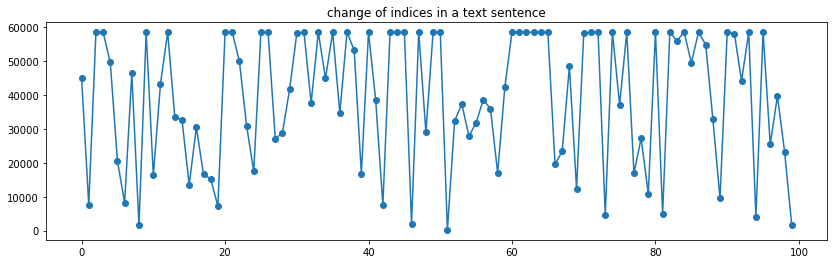

In [18]:
plt.figure(figsize=(14,4))
plt.plot(xtrain[0], '-o')
plt.title('change of indices in a text sentence');

In [19]:
word2indx['<UNK>']

58439

In [20]:
unique, counts = np.unique(xtrain[0], return_counts=True)
print(unique, counts)
print(indx2word[unique[np.argmax(counts)]])

[  206  1558  2078  3991  4653  4872  7172  7537  7682  8218  9465 10854
 12391 13496 15251 16285 16549 16758 16973 17448 19555 20460 23260 23335
 25394 27037 27142 27789 28849 28965 30390 30927 31790 32332 32611 32953
 33378 34737 35857 37124 37278 37580 38427 38603 39692 41653 42226 43261
 44135 44855 46338 48405 49418 49532 49861 53165 54789 55942 58011 58088
 58439] [ 1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  1  1  1  1  1  1  1  1  1  2 36]
<UNK>


---
## Dataset and Dataloader for PyTorch NN Modeling

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x  # np.array(N, max_len)
        self.y = y  # label
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [23]:
ds = Dataset(xtrain, ytr)
ds[21110]

(array([14484, 58439, 58439, 49393, 58439, 45376, 58439, 52023, 48619,
        33127, 58439,   689, 24962, 58439, 58439, 58439, 52998, 58439,
        31654, 24846, 58439, 58439, 57547, 30390, 58439, 58439, 58439,
        58439, 37311, 45858, 50467, 48069, 58439, 58439, 18433,  6855,
        49046, 10196, 42963, 34770, 37857, 58439, 31654,  1301, 58439,
        58439, 58439, 58439, 50088, 58439, 10307, 16973, 37311, 42963,
        53312, 20099,  3452, 58439, 51220, 14227, 58439, 30136, 10919,
        58439,  6560, 58439, 52081, 57547, 20259, 58439, 14227, 58439,
        37213, 52127, 54688, 48069, 58439, 58439, 18433,  6855, 37376,
        42963, 58439, 51896, 18211, 58439, 58439, 27586, 21601, 58439,
        29177, 11609, 51331, 31654, 58439, 58439, 12873, 42468, 36273,
        58439], dtype=int64), 0)

In [24]:
batch_size = 4
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

In [25]:
print(len(data_loader['train'].dataset), len(data_loader['val'].dataset))

for x, y in data_loader['train']:
    print(x.dtype, y.dtype)
    print(x.shape, y)
    break

25000 25000
torch.int64 torch.int64
torch.Size([4, 100]) tensor([0, 1, 1, 1])


## Network Design
Very simple FF linear model:
1. nn.Embedding: word_index -> Euclidean Vector Mapping
1. nn.Conv1D()
1. nn.Linear()
1. Softmax + CrossEntropy = CrossEntropyLoss

### Practice layer by layer

#### nn.Embedding()

* Remember the output shape from embedding.
    - Batch x Sequence(Time) x Feature

In [33]:
vocab_size = len(vocab)
embed_dim = 9

emb = nn.Embedding(num_embeddings=vocab_size, 
                   embedding_dim=embed_dim,
                   padding_idx=word2indx['<PAD>'])

print( emb.weight.shape,'\n', emb.weight)
print('---')
for x, y in data_loader['train']:
    r = emb(x)
    print(f'input({x.shape}) --> embedded({r.shape})')
    break

torch.Size([58441, 9]) 
 Parameter containing:
tensor([[-2.3341, -2.2948, -1.1292,  ...,  0.3603, -0.1731,  1.7707],
        [ 0.0266, -1.5368,  0.1980,  ..., -1.5043, -1.2940,  1.9209],
        [-1.6695, -1.0292,  1.0057,  ..., -0.9184, -0.3051, -0.4888],
        ...,
        [-0.7836, -1.8050,  0.0609,  ..., -0.0762, -0.1081, -1.6503],
        [-1.5334, -1.6531, -0.6113,  ...,  0.7073, -0.7565, -0.7172],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)
---
input(torch.Size([4, 100])) --> embedded(torch.Size([4, 100, 9]))


#### nn.Conv1D()

- to apply the output of embedding, we changed the order of index

In [34]:
kernel_size = 11
out_channels= 5
conv1d = nn.Conv1d(in_channels=embed_dim, 
                   out_channels=out_channels, 
                   kernel_size=kernel_size, 
                   stride=1,
                   padding=kernel_size//2)  # <---- the same length in the output

r_perm = r.permute(0,2,1)
print(f'r_perm shape: {r_perm.shape}')
f = conv1d(r_perm)
print(f'conv1d shape: {f.shape}')

r_perm shape: torch.Size([4, 9, 100])
conv1d shape: torch.Size([4, 5, 100])


In [35]:
conv1d.out_channels, conv1d.stride

(5, (1,))

In [36]:
kernel_size = 11
out_channels=5
conv1d = nn.Conv1d(in_channels=embed_dim, 
                   out_channels=out_channels, 
                   kernel_size=kernel_size, 
                   stride=kernel_size//2,    # <---- the filter now jumps
                   padding=kernel_size//2)

r_perm = r.permute(0,2,1)
print(f'r_perm shape: {r_perm.shape}')
f = conv1d(r_perm)
print(f'conv1d shape: {f.shape}')

r_perm shape: torch.Size([4, 9, 100])
conv1d shape: torch.Size([4, 5, 20])


#### nn.Linear()

In [37]:
in_dim = f.shape[-1] * f.shape[-2]
out_dim = 2 # sentiment: [pos, neg]
linear = nn.Linear(in_features=in_dim, out_features=2)

flatten = nn.Flatten()
score = linear(flatten(f))

print(score.shape)

torch.Size([4, 2])


### Make NN Model
- Pytorch Custom Module: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

In [38]:
class Conv1dModel(nn.Module):
    def __init__(self, vocab_len, kernel_size=5, out_channels=5, embedding_dim=40, seq_len=100, n_targets=2):
        super(Conv1dModel, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_len, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=word2indx['<PAD>'])
        
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, 
                               out_channels=out_channels, 
                               kernel_size=kernel_size, 
                               stride=kernel_size//2, padding=kernel_size//2) # [B, 5, 20]
        
        self.tanh = nn.Tanh()
        
        self.flatten = nn.Flatten()

        # nn.Linear() depends on the size of input sequence. 
        # We can avoid this using AdaptiveAvgPool1d(); comes later
        #
        in_features = int((self.conv1.out_channels * seq_len) / self.conv1.stride[0]) # calculate!
        self.linear = nn.Linear(in_features=in_features, out_features=n_targets)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.permute(0,2,1)
        x =  self.tanh(self.conv1(x))
        x = self.flatten(x)
        x = self.linear(x)
        
        return x
#

class Conv1dModel_AvgPooling(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, kernel_size=5, n_target=2):
        super(Conv1dModel_AvgPooling, self).__init__()
        emb_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=pad_indx)
        self.conv1 = nn.Conv1d(emb_dim,    emb_dim//2, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv2 = nn.Conv1d(emb_dim//2, emb_dim//4, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv3 = nn.Conv1d(emb_dim//4, n_target,   kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.bn1 = nn.BatchNorm1d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm1d(self.conv2.out_channels)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1) # NLC -> NCL
        x = nn.functional.elu(self.bn1(self.conv1(x)))
        x = nn.functional.elu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        return x
#

def make_model(vocab_size, embedding_dim, kernel_size=5, option=1):
    if option == 1:
        return Conv1dModel(vocab_size, embedding_dim=embedding_dim, kernel_size=kernel_size, out_channels=50)
    elif option == 2:
        return Conv1dModel_AvgPooling(vocab_size, embedding_dim=embedding_dim, kernel_size=kernel_size, n_target=2)
    else:
        return None
#

In [39]:
net = make_model(vocab_size, embedding_dim=50)
print(net)
net(x).shape

Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)


torch.Size([4, 2])

In [40]:
net = make_model(vocab_size, embedding_dim=50, option=2)
print(net)
print(net(x).shape)

Conv1dModel_AvgPooling(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 25, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(25, 12, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(12, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([4, 2])


## Training Loop

In [41]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None, lr_scheduler=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = []
        
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated: {best_acc} at epoch {epoch}.')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss)
            hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc)
            hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    model.train()
    return loss, acc
#

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#

def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Training Setup

In [42]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # for debuging
print(device)


model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embeddin))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
2939602


In [43]:
count_params(model.embedding)

2922050

## First Trial

Epoch 1, tloss 13.08 t_acc: 0.51  vloss 2.67  v_acc: 0.57
 >> best val accuracy updated: 0.56808 at epoch 1.
Epoch 2, tloss 1.75 t_acc: 0.67  vloss 1.70  v_acc: 0.67
 >> best val accuracy updated: 0.67076 at epoch 2.
Epoch 3, tloss 0.72 t_acc: 0.83  vloss 1.44  v_acc: 0.71
 >> best val accuracy updated: 0.70736 at epoch 3.
Epoch 4, tloss 0.36 t_acc: 0.90  vloss 1.47  v_acc: 0.72
 >> best val accuracy updated: 0.72336 at epoch 4.
Epoch 5, tloss 0.19 t_acc: 0.94  vloss 1.49  v_acc: 0.73
 >> best val accuracy updated: 0.73252 at epoch 5.
 >> best val accuracy updated: 0.73696 at epoch 6.
 >> best val accuracy updated: 0.74508 at epoch 8.
Epoch 10, tloss 0.02 t_acc: 0.99  vloss 1.97  v_acc: 0.75
 >> best val accuracy updated: 0.74852 at epoch 10.
finished training_loop().
Wall time: 7.63 s


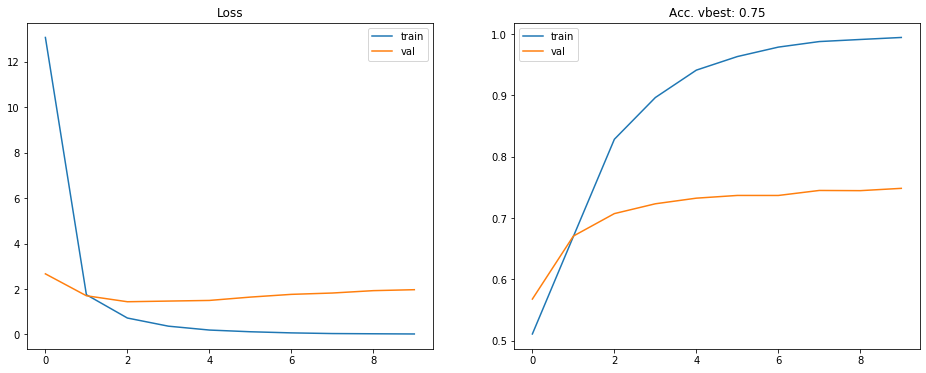

In [44]:
%%time
history = training_loop(10, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

Epoch 1, tloss 0.01 t_acc: 1.00  vloss 2.06  v_acc: 0.75
 >> best val accuracy updated: 0.74744 at epoch 1.
Epoch 2, tloss 0.00 t_acc: 1.00  vloss 2.09  v_acc: 0.75
Epoch 3, tloss 0.00 t_acc: 1.00  vloss 2.09  v_acc: 0.75
 >> best val accuracy updated: 0.7484 at epoch 3.
Epoch 4, tloss 0.00 t_acc: 1.00  vloss 2.07  v_acc: 0.75
 >> best val accuracy updated: 0.74952 at epoch 4.
Epoch 5, tloss 0.00 t_acc: 1.00  vloss 2.07  v_acc: 0.75
 >> best val accuracy updated: 0.75036 at epoch 5.
Epoch 10, tloss 0.00 t_acc: 1.00  vloss 2.07  v_acc: 0.75
finished training_loop().
Wall time: 6.03 s


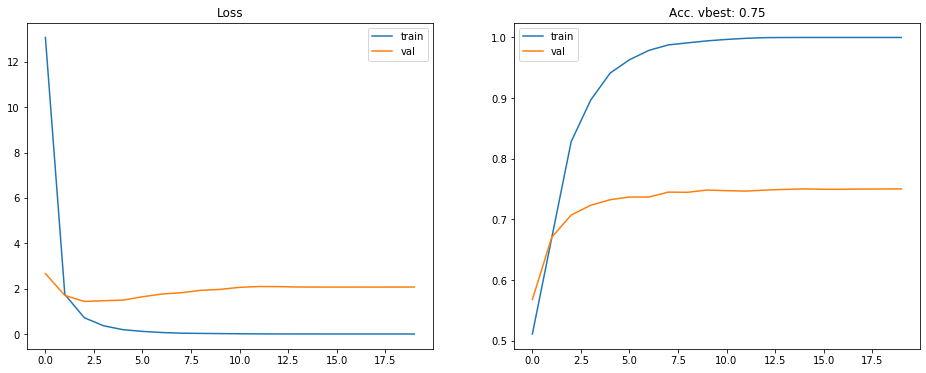

In [45]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Try with CosineAnnealing()

In [59]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  2939602 embeddin:  2922050


## First Trial

Epoch 1, tloss 18.87 t_acc: 0.50  vloss 4.42  v_acc: 0.52
 >> best val accuracy updated: 0.52344 at epoch 1.
Epoch 2, tloss 2.82 t_acc: 0.61  vloss 2.24  v_acc: 0.61
 >> best val accuracy updated: 0.61 at epoch 2.
Epoch 3, tloss 0.97 t_acc: 0.78  vloss 1.56  v_acc: 0.68
 >> best val accuracy updated: 0.67668 at epoch 3.
Epoch 4, tloss 0.43 t_acc: 0.87  vloss 1.36  v_acc: 0.70
 >> best val accuracy updated: 0.70208 at epoch 4.
Epoch 5, tloss 0.19 t_acc: 0.93  vloss 1.33  v_acc: 0.71
 >> best val accuracy updated: 0.7104 at epoch 5.
 >> best val accuracy updated: 0.71216 at epoch 6.
 >> best val accuracy updated: 0.71872 at epoch 7.
 >> best val accuracy updated: 0.72004 at epoch 12.
 >> best val accuracy updated: 0.7202 at epoch 15.
 >> best val accuracy updated: 0.72036 at epoch 19.
 >> best val accuracy updated: 0.72044 at epoch 20.
 >> best val accuracy updated: 0.72084 at epoch 21.
 >> best val accuracy updated: 0.72132 at epoch 23.
 >> best val accuracy updated: 0.72144 at epoch 24

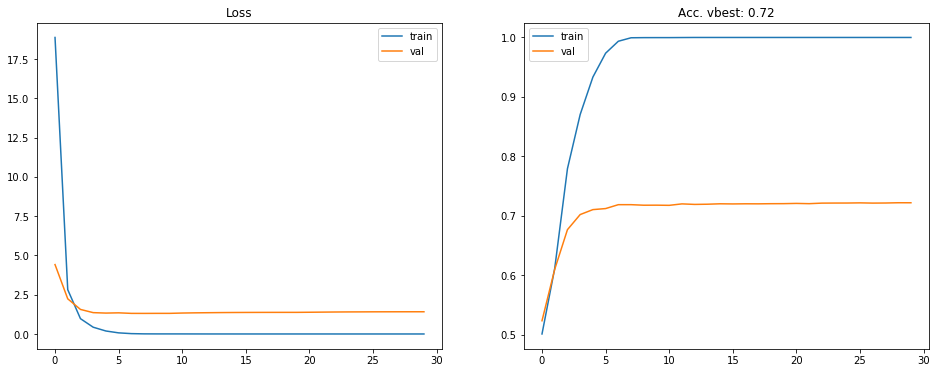

In [60]:
%%time
history = training_loop(30, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

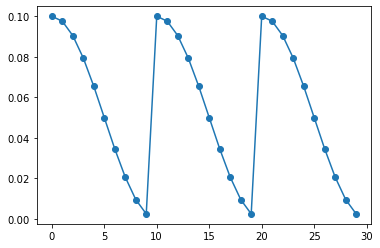

In [61]:
plt.plot(history['lr'], '-o')

## Overfitting is occurring!
Below
- lr_scheduler change
- The same result
- more data!

## With smaller learning rate

In [63]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  2939602 embeddin:  2922050


## First Trial

Epoch 1, tloss 0.57 t_acc: 0.71  vloss 0.67  v_acc: 0.61
 >> best val accuracy updated: 0.61328 at epoch 1.
Epoch 2, tloss 0.53 t_acc: 0.74  vloss 0.67  v_acc: 0.63
 >> best val accuracy updated: 0.6298 at epoch 2.
Epoch 3, tloss 0.49 t_acc: 0.77  vloss 0.66  v_acc: 0.64
 >> best val accuracy updated: 0.64416 at epoch 3.
Epoch 4, tloss 0.45 t_acc: 0.80  vloss 0.66  v_acc: 0.66
 >> best val accuracy updated: 0.65772 at epoch 4.
Epoch 5, tloss 0.41 t_acc: 0.82  vloss 0.66  v_acc: 0.66
 >> best val accuracy updated: 0.6646 at epoch 5.
 >> best val accuracy updated: 0.67028 at epoch 6.
 >> best val accuracy updated: 0.67232 at epoch 7.
 >> best val accuracy updated: 0.67536 at epoch 8.
 >> best val accuracy updated: 0.6772 at epoch 9.
 >> best val accuracy updated: 0.67756 at epoch 10.
 >> best val accuracy updated: 0.67852 at epoch 11.
 >> best val accuracy updated: 0.6788 at epoch 12.
 >> best val accuracy updated: 0.68548 at epoch 13.
 >> best val accuracy updated: 0.69124 at epoch 14.


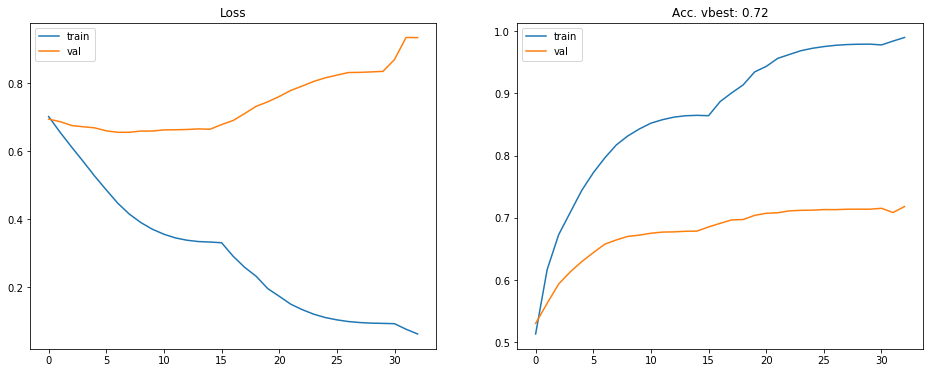

In [65]:
%%time
history = training_loop(30, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Reduced Embedding Dim for the 2nd Model with AvgPooling1D()

In [76]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=2).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 2, padding_idx=58440)
  (conv1): Conv1d(2, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  122434 embeddin:  116882


## First Trial

Epoch 1, tloss 0.00 t_acc: 1.00  vloss 2.91  v_acc: 0.74
 >> best val accuracy updated: 0.74032 at epoch 1.
Epoch 2, tloss 0.00 t_acc: 1.00  vloss 2.92  v_acc: 0.74
 >> best val accuracy updated: 0.74044 at epoch 2.
Epoch 3, tloss 0.00 t_acc: 1.00  vloss 2.94  v_acc: 0.74
Epoch 4, tloss 0.00 t_acc: 1.00  vloss 2.95  v_acc: 0.74
 >> best val accuracy updated: 0.74048 at epoch 4.
Epoch 5, tloss 0.00 t_acc: 1.00  vloss 2.96  v_acc: 0.74
 >> best val accuracy updated: 0.74056 at epoch 11.
 >> best val accuracy updated: 0.7406 at epoch 21.
 >> best val accuracy updated: 0.74076 at epoch 24.
Epoch 40, tloss 0.00 t_acc: 1.00  vloss 3.16  v_acc: 0.74
 >> best val accuracy updated: 0.7408 at epoch 40.
finished training_loop().
Wall time: 22.2 s


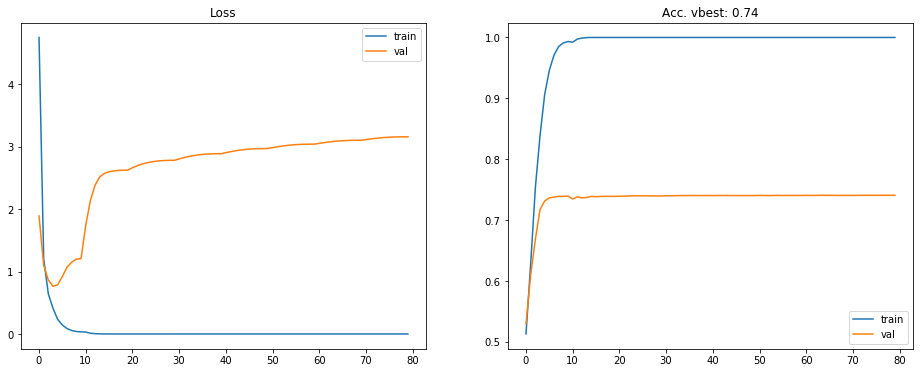

In [135]:
%%time
history = training_loop(40, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Embedding Space Analysis

torch.Size([58441, 2])
x:  (25000, 100) <class 'numpy.ndarray'>
unique(x[y==0]):  (44707,)
unique(x[y==1]):  (44949,)
x:  torch.Size([25000, 1, 100])
e:  torch.Size([25000, 1, 100, 2])
25000 <class 'numpy.ndarray'> (12500,) [0 0 0 ... 0 0 0]
en, ep:  torch.Size([12500, 1, 100, 2]) torch.Size([12500, 1, 100, 2])
torch.Size([12500, 1, 100, 2])
en, ep:  torch.Size([1250000, 2]) torch.Size([1250000, 2])


Text(0.5, 1.0, 'Embedding weight vectors. G: all, B: pos, R: neg')

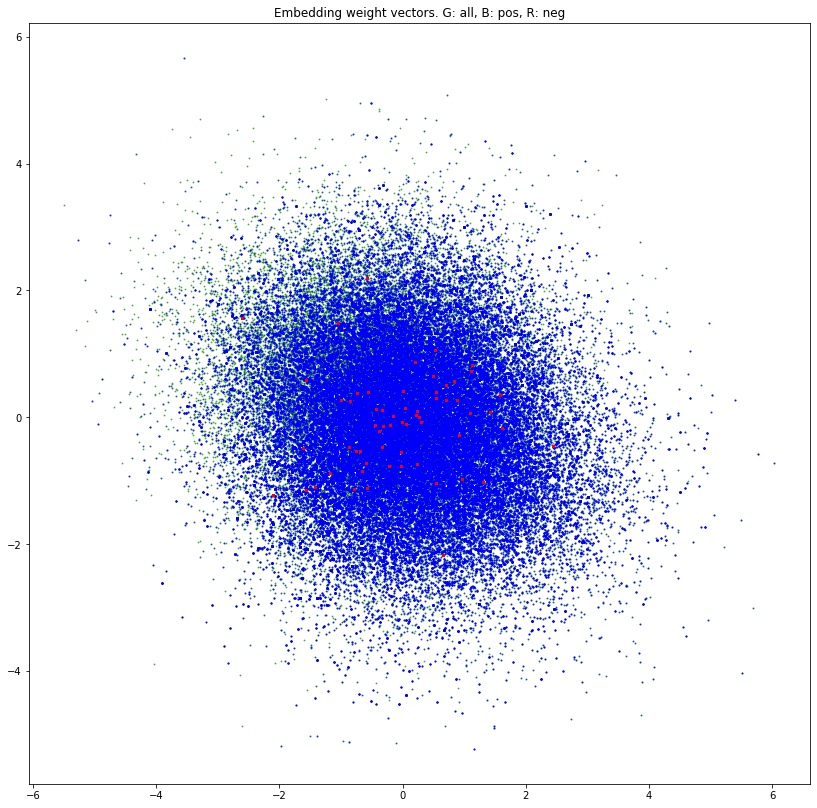

In [193]:
plt.figure(figsize=(14,14))
w = model.embedding.weight.data.cpu()
print(w.shape)
plt.scatter(w[:,0], w[:,1], alpha=0.5, s=1, c='g') # un-used weights exist due to sentence trimming.

with torch.no_grad():
    x, y = data_loader['train'].dataset[:] # the first in the dataset
    y = np.array(y)
    
    print('x: ', x.shape, type(x))
    uniq = np.unique(x[y==0])
    print('unique(x[y==0]): ', uniq.shape)
    print('unique(x[y==1]): ', np.unique(x[y==1]).shape)
    
    x = torch.from_numpy(x).to(device).unsqueeze(1) #
    print('x: ', x.shape)
    e = model.embedding(x).cpu()
print('e: ', e.shape)

yn = y[y==0]
print(len(y), type(y), yn.shape, yn)

e_neg = e[yn]
e_pos = e[y==1]
print('en, ep: ', e_neg.shape, e_pos.shape)
print(e_neg.shape)

e_neg = e_neg.reshape(-1,2)
e_pos = e_pos.reshape(-1,2)
print('en, ep: ', e_neg.shape, e_pos.shape)

plt.scatter(e_pos[:,0], e_pos[:,1], c='b', alpha=0.3, s=1)
plt.scatter(e_neg[:,0], e_neg[:,1], c='r', alpha=0.3, s=2)

plt.title('Embedding weight vectors. G: all, B: pos, R: neg')
# 

torch.Size([1250000, 2])


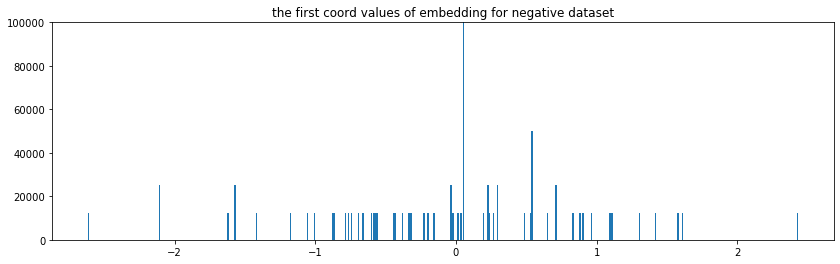

In [187]:
print(e_neg.shape)
plt.figure(figsize=(14,4))
plt.hist(e_neg[:,0].reshape(-1), bins=500)
plt.ylim((0,100000))
plt.title('the first coord values of embedding for negative dataset');

torch.Size([25000, 1, 100, 2])

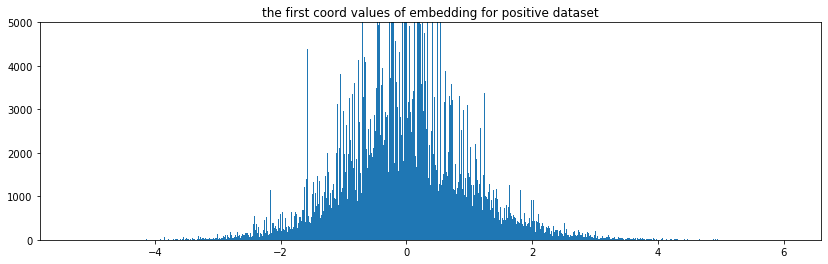

In [191]:
plt.figure(figsize=(14,4))
plt.hist(e_pos[:,0].reshape(-1), bins=1000)
plt.ylim((0,5000))
plt.title('the first coord values of embedding for positive dataset')
e.shape

## Hypter parameters
- the number of words (size of vocab)
- maximum length of the sequence
- embedding dimension
- size of linear network
- learning rate, schedule

## References
- [https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data](https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data)
- https://github.com/lesley2958/twilio-sent-analysis
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch

End.